In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import our pricer and model classes
from base_model import BaseModel
from MCPricer import MCPricer
from pdv_model import PDVModel
from gridinterp import *

from BScalculator import *

In [2]:
df = pd.read_csv('SPXllv.csv')
# df = pd.read_csv('implied_vol.csv')
df.head(10)

,moneyness_tenor,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1
0,0.3,0.50,0.45,0.42,0.40,0.38,0.360,0.340,0.320,0.300,0.280
1,0.4,0.42,0.38,0.36,0.34,0.32,0.300,0.280,0.260,0.240,0.220
2,0.5,0.35,0.32,0.30,0.28,0.26,0.250,0.240,0.220,0.200,0.190
3,0.6,0.30,0.28,0.26,0.24,0.22,0.210,0.200,0.190,0.180,0.180
4,0.7,0.25,0.23,0.22,0.20,0.19,0.180,0.180,0.180,0.180,0.190
5,0.8,0.20,0.19,0.18,0.17,0.17,0.170,0.180,0.190,0.200,0.210
6,0.9,0.16,0.15,0.16,0.16,0.17,0.180,0.190,0.200,0.210,0.220
7,1.0,0.14,0.15,0.16,0.17,0.18,0.190,0.195,0.200,0.205,0.210
8,1.1,0.15,0.16,0.17,0.18,0.19,0.195,0.200,0.205,0.210,0.215
9,1.2,0.16,0.17,0.18,0.19,0.20,0.200,0.205,0.210,0.215,0.220


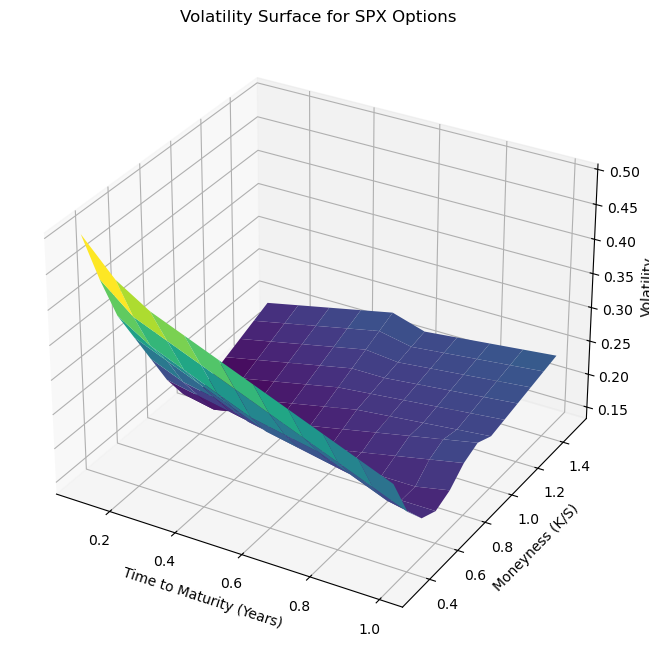

In [3]:
# time_points, moneyness_points, vol_data = generate_sample_data()
time_points = np.array([float(col) for col in df.columns[1:]])  # Extract time to maturity from the header
moneyness_points = df['moneyness_tenor'].values  # Extract moneyness (K/S) from the first column
vol_data = df.iloc[:, 1:].values.T  # Extract the volatility data from the DataFrame

# Create the grid interpolator
grid_interpolator = GridInterpolator(time_points, moneyness_points, vol_data)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  
# Extract strike (K/S) values from the first column
strikes = df['moneyness_tenor'].values
# Extract time to maturity values from the header (skipping the first column)
maturities = np.array([float(col) for col in df.columns[1:]]) 

volatility = np.zeros((len(maturities), len(strikes)))
for i in range(len(maturities)):
    volatility[i, :] = grid_interpolator.get_vol(maturities[i], strikes)

# Create a meshgrid for the surface plot
M, S = np.meshgrid(maturities, strikes)
# Plot the surface
ax.plot_surface(M, S, volatility.T, cmap='viridis', edgecolor='none')
ax.set_xlabel('Time to Maturity (Years)')
ax.set_ylabel('Moneyness (K/S)')
ax.set_zlabel('Volatility')
ax.set_title('Volatility Surface for SPX Options')
plt.show()

In [4]:
class LocalVolModel(BaseModel):
    def __init__(self, s0: float, grid_interpolator, dt: float = 1/252):
        super().__init__(s0, 0.0, x_dimensions=1)  # x0 not used for this model
        self.grid_interpolator = grid_interpolator
        self.dt = dt
        
    def sigma(self, t: float, S: np.ndarray, X: np.ndarray) -> np.ndarray:
        """Return constant volatility regardless of state"""
        return self.dupire_vol(t, S)
    
    def dupire_vol(self, t: float, S: np.ndarray) -> np.ndarray:
        """Return local vol local volatility surface"""
        return self.grid_interpolator.get_vol(t, S / self.s0)  # Normalize S by initial price s0  
    
    def update_X(self, t: float) -> np.ndarray:
        """No state variables to update in this model"""
        return np.zeros(1)  # Return dummy value as this model doesn't use X

In [5]:
# Set up common parameters
S0 = 100.0  # Initial stock price
risk_free_rate = 0.0  # 3% risk-free rate
dividend_yield = 0.0  # 1% dividend yield
dt = 1/252  # Daily time steps (252 trading days per year)

local_vol_model = LocalVolModel(s0=S0, grid_interpolator=grid_interpolator, dt=dt)

dupire_vol = lambda t, s: grid_interpolator.get_vol(t, s/pdv_model.s0)

pdv_model = PDVModel(
    s0=S0, 
    x0=S0,  # Initialize X0 to S0 for VWAP
    dt=dt,
    Delta=1/12,  # 1 month lookback for PDV
    kappa=0.8,  # Mean reversion strength
    sigma0=0.2,
    X_type='VWAP',  # Use volume weighted average price as the path-dependent factor
    sigma_type=1,  # Simple sigma model
    dupire_vol_interp=dupire_vol
)

print(f"Risk-free rate: {risk_free_rate*100:.1f}%, Dividend yield: {dividend_yield*100:.1f}%")

Risk-free rate: 0.0%, Dividend yield: 0.0%


In [6]:
# Set up Monte Carlo simulation parameters
num_paths = 100_000  # Number of paths for final simulation
num_particles = 50_000  # Number of particles for leverage calibration (only used in PDV model)
time_steps = 252  # Number of time steps (1 year of trading days)

# Initialize Monte Carlo pricers
mc_local_vol = MCPricer(
    model=local_vol_model,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield,
    use_antithetic=False,  # No antithetic variates for this demo
    rng=np.random.default_rng(42)  # Set seed for reproducibility
)

mc_pdv = MCPricer(
    model=pdv_model,
    risk_free_rate=risk_free_rate,
    dividend_yield=dividend_yield,
    use_antithetic=False,
    rng=np.random.default_rng(42)  # Use same seed for fair comparison
)

# Set up the local vol simulation
mc_local_vol.setup_simulation(
    num_paths=num_paths, 
    time_steps=time_steps, 
    dt=dt,
    use_local_vol_simulator=True  # Explicitly use LocalVolSimulator
)
mc_local_vol.run_simulation()

# Set up the PDV model simulation
mc_pdv.setup_simulation(
    num_paths=num_paths,  # This is used for the final simulation
    time_steps=time_steps, 
    dt=dt,
    use_local_vol_simulator=False  # Use ParticleMonteCarlo for PDV
)
mc_pdv.run_simulation()

print()

Using LocalVolSimulator for local volatility model
Simulating Local Volatility Model
Using ParticleMonteCarlo for path-dependent volatility model
Simulating PDVModel
Using 10000 particles to initialize leverage surface



In [7]:
# Define forward start option parameters
option_types = ['call', 'put']
strike_percentages = [0.95, 1.05]  # Strikes at 95% and 105% of forward price
start_time = [0, 1/12, 1/6, 1/4, 1/3, 1/2]  # Start times in years (1 month, 2 months, 3 months, 4 months, 6 months)
expiry = [t + 1/12 for t in start_time]  # Expiry is 1 month after start time

print("\nPricing forward start options spread with the following parameters:")
print(f"Option types: {option_types}")
print(f"Strike percentages: {strike_percentages} (of forward price)")
print(f"Start times: {[f'{t*12:.1f} months' for t in start_time]}")
print(f"Expiries: {[f'{t*12:.1f} months' for t in expiry]}")
print(f"Spreads: {option_types[0].capitalize()} {strike_percentages[0]} - {strike_percentages[1]} and {option_types[1].capitalize()} {strike_percentages[0]} - {strike_percentages[1]}")


Pricing forward start options spread with the following parameters:
Option types: ['call', 'put']
Strike percentages: [0.95, 1.05] (of forward price)
Start times: ['0.0 months', '1.0 months', '2.0 months', '3.0 months', '4.0 months', '6.0 months']
Expiries: ['1.0 months', '2.0 months', '3.0 months', '4.0 months', '5.0 months', '7.0 months']
Spreads: Call 0.95 - 1.05 and Put 0.95 - 1.05


In [8]:
# Create dataframes to store results for both models
results = []

# Loop through all combinations of option types, strikes, and times
for opt_type in option_types:
    for idx, s_time in enumerate(start_time):
        e_time = expiry[idx]
        
        # Calculate prices for both strike percentages with flat vol model
        localvol_low_price = mc_local_vol.price_forward_start(opt_type, strike_percentages[0], s_time, e_time)
        localvol_high_price = mc_local_vol.price_forward_start(opt_type, strike_percentages[1], s_time, e_time)
        
        # Calculate spread for localvol vol model
        localvol_spread = localvol_low_price['price'] - localvol_high_price['price']
        
        # Calculate prices for both strike percentages with PDV model
        pdv_low_price = mc_pdv.price_forward_start(opt_type, strike_percentages[0], s_time, e_time)
        pdv_high_price = mc_pdv.price_forward_start(opt_type, strike_percentages[1], s_time, e_time)
        
        # Calculate spread for PDV model
        pdv_spread = pdv_low_price['price'] - pdv_high_price['price']
        
        # Store results
        results.append({
            'Option Type': opt_type.capitalize(),
            'Start Time (months)': s_time * 12,
            'Expiry (months)': e_time * 12,
            f'{strike_percentages[0]} Price (localvol Vol)': localvol_low_price['price'],
            f'{strike_percentages[1]} Price (localvol Vol)': localvol_high_price['price'],
            f'Spread {strike_percentages[0]}-{strike_percentages[1]} (localvol Vol)': localvol_spread,
            f'{strike_percentages[0]} Price (PDV)': pdv_low_price['price'],
            f'{strike_percentages[1]} Price (PDV)': pdv_high_price['price'],
            f'Spread {strike_percentages[0]}-{strike_percentages[1]} (PDV)': pdv_spread,
            'Spread Difference (PDV - localvol)': pdv_spread - localvol_spread
        })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
display(results_df)

,Option Type,Start Time (months),Expiry (months),0.95 Price (localvol Vol),1.05 Price (localvol Vol),Spread 0.95-1.05 (localvol Vol),0.95 Price (PDV),1.05 Price (PDV),Spread 0.95-1.05 (PDV),Spread Difference (PDV - localvol)
0,Call,0.0,1.0,0.051942,0.002077,0.049866,0.052049,0.002084,0.049966,0.000100
1,Call,1.0,2.0,0.052415,0.002676,0.049740,0.053997,0.001117,0.052880,0.003140
2,Call,2.0,3.0,0.052524,0.003139,0.049386,0.054722,0.001102,0.053619,0.004233
3,Call,3.0,4.0,0.053208,0.003777,0.049431,0.055555,0.001242,0.054313,0.004882
4,Call,4.0,5.0,0.053408,0.004277,0.049131,0.056113,0.001427,0.054686,0.005555
5,Call,6.0,7.0,0.054861,0.005530,0.049332,0.057560,0.001853,0.055707,0.006375
6,Put,0.0,1.0,0.002007,0.052141,-0.050134,0.002113,0.052147,-0.050034,0.000100
7,Put,1.0,2.0,0.002346,0.052606,-0.050260,0.003950,0.051070,-0.047120,0.003140
8,Put,2.0,3.0,0.002634,0.053248,-0.050614,0.004745,0.051126,-0.046381,0.004233
9,Put,3.0,4.0,0.003143,0.053712,-0.050569,0.005507,0.051194,-0.045687,0.004882


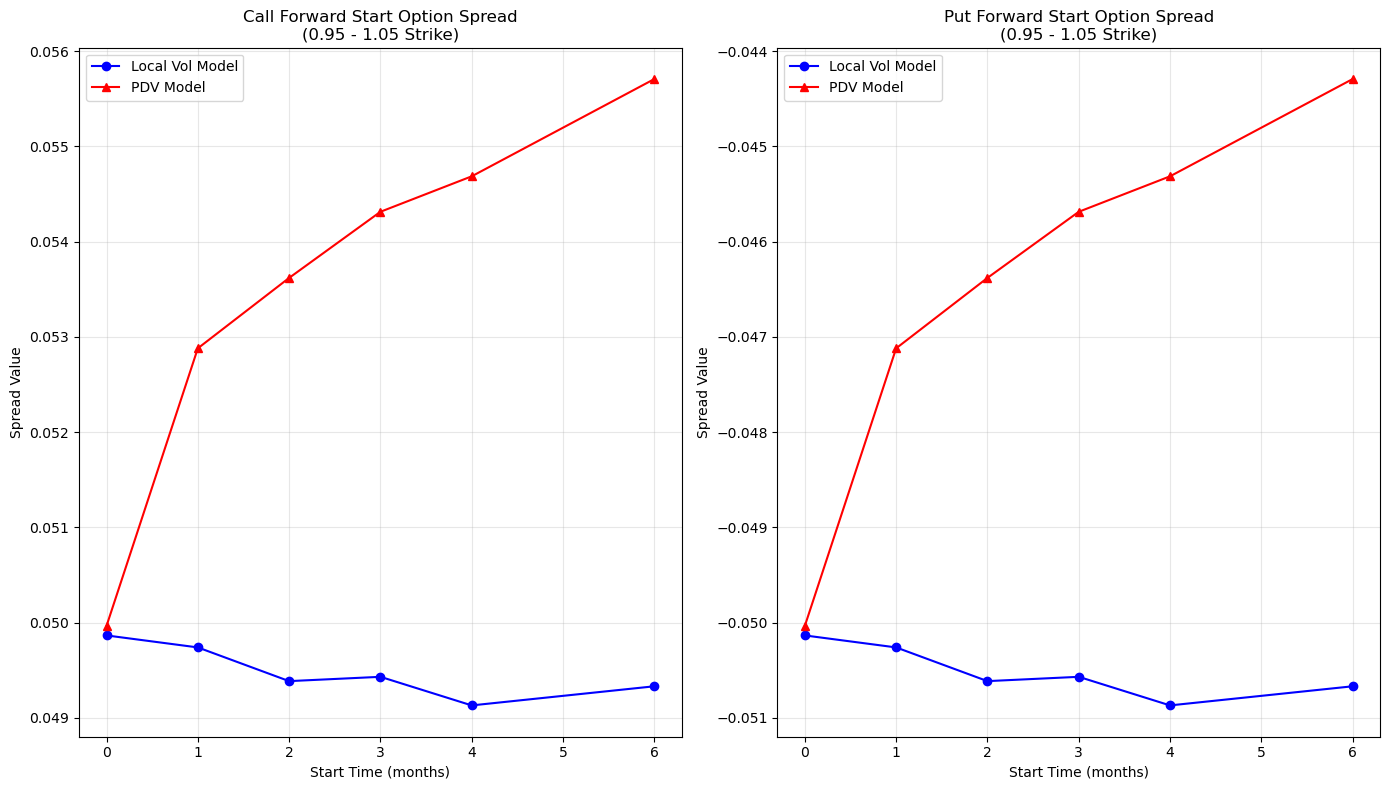

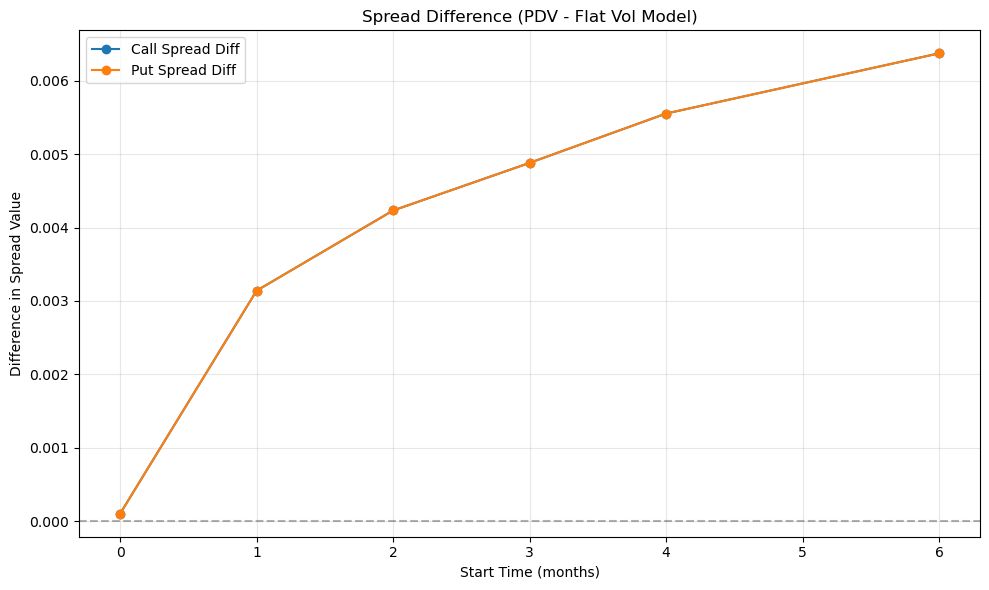

In [11]:
# Visualize the forward start option spreads
plt.figure(figsize=(14, 8))

# Plot call and put spreads side by side
for i, opt_type in enumerate(option_types):
    # Filter data for this option type
    opt_data = results_df[results_df['Option Type'] == opt_type.capitalize()]
    
    plt.subplot(1, 2, i+1)
    
    # Plot spread for localvol vol and PDV models
    plt.plot(opt_data['Start Time (months)'], 
             opt_data[f'Spread {strike_percentages[0]}-{strike_percentages[1]} (localvol Vol)'], 
             'b-o', label='Local Vol Model')
    
    plt.plot(opt_data['Start Time (months)'], 
             opt_data[f'Spread {strike_percentages[0]}-{strike_percentages[1]} (PDV)'], 
             'r-^', label='PDV Model')
    
    plt.title(f'{opt_type.capitalize()} Forward Start Option Spread\n({strike_percentages[0]} - {strike_percentages[1]} Strike)', fontsize=12)
    plt.xlabel('Start Time (months)')
    plt.ylabel('Spread Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
plt.tight_layout()
plt.show()

# Plot spread differences (PDV - Flat Vol)
plt.figure(figsize=(10, 6))

# Group by option type
for opt_type in option_types:
    opt_data = results_df[results_df['Option Type'] == opt_type.capitalize()]
    plt.plot(opt_data['Start Time (months)'], 
             opt_data['Spread Difference (PDV - localvol)'], 
             marker='o', label=f'{opt_type.capitalize()} Spread Diff')

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.title('Spread Difference (PDV - Flat Vol Model)', fontsize=12)
plt.xlabel('Start Time (months)')
plt.ylabel('Difference in Spread Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

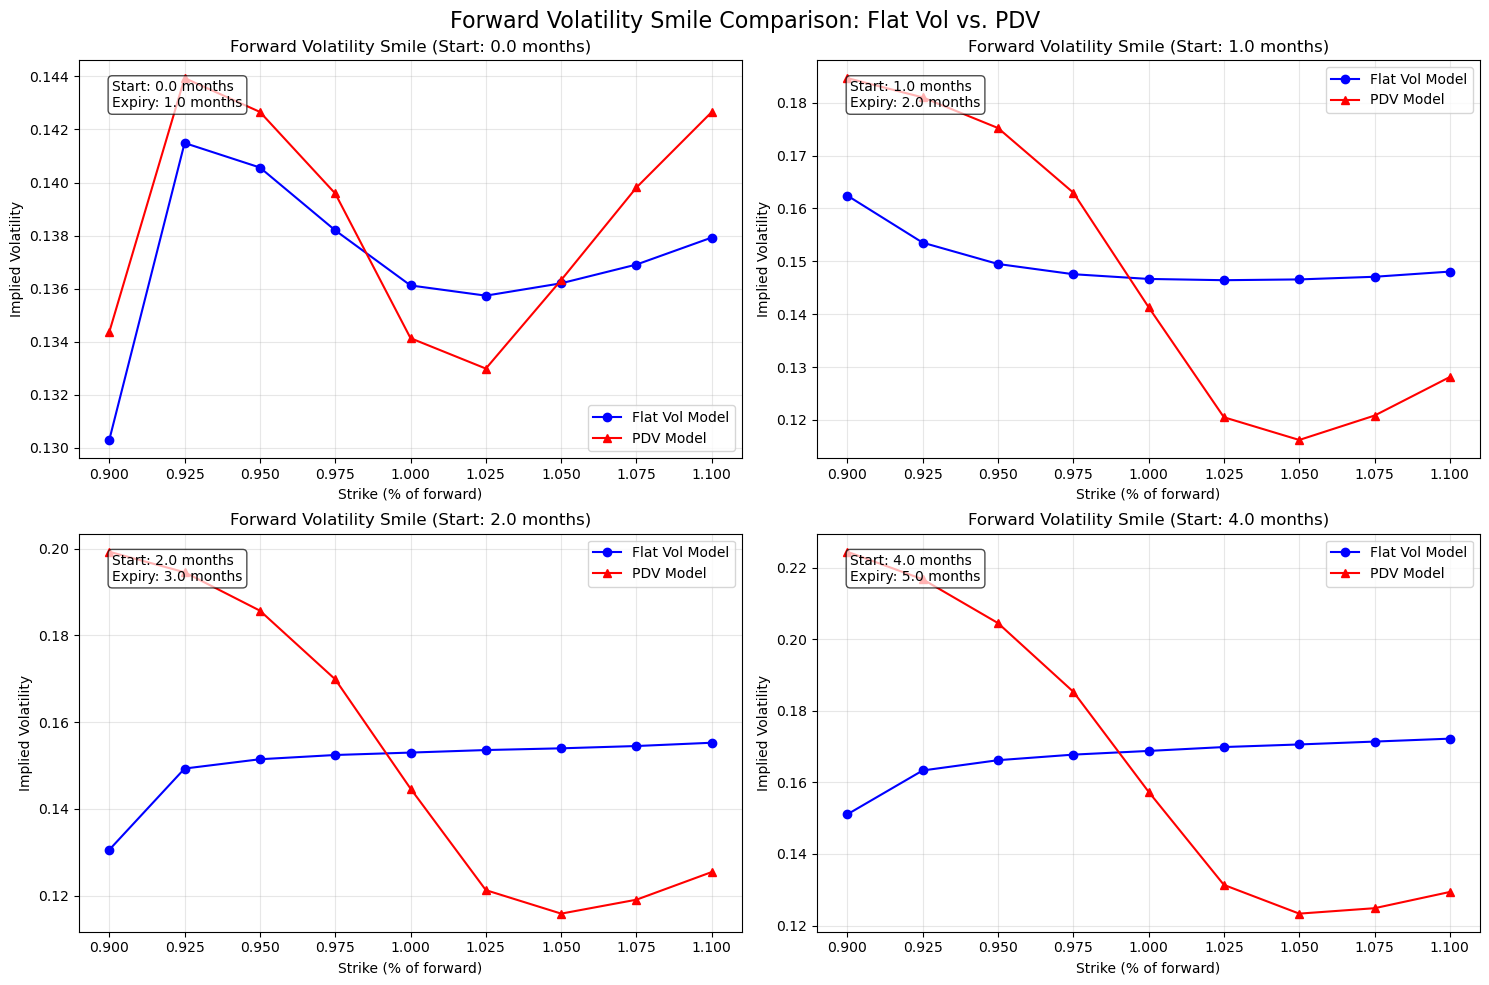

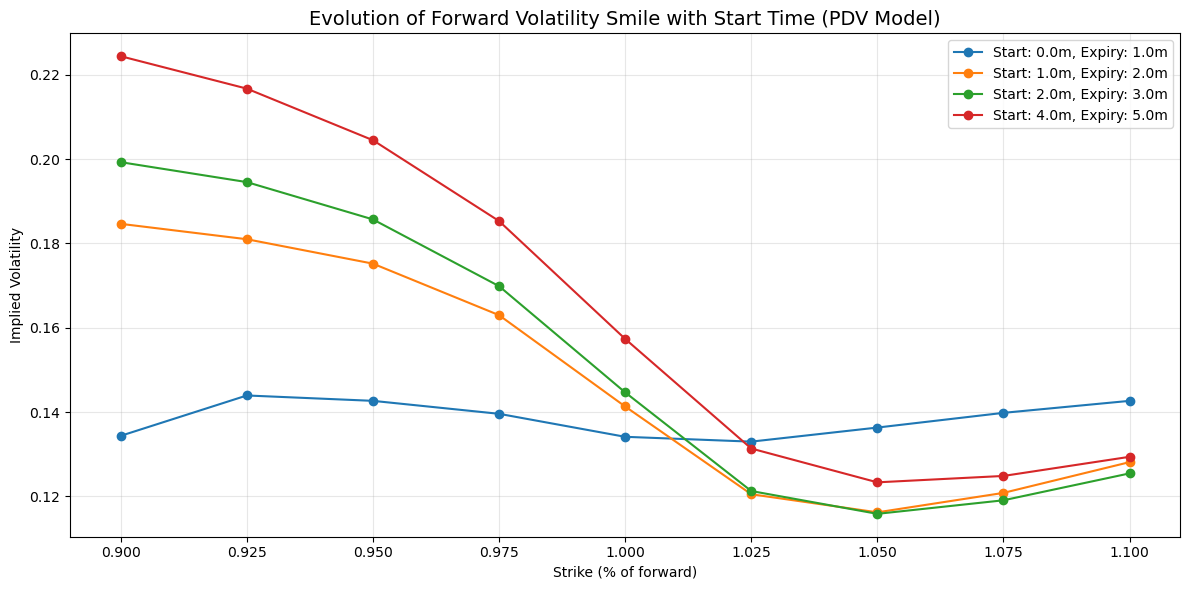

In [12]:
# Define parameters for forward volatility smile analysis
strike_percentages = np.linspace(0.9, 1.1, 9)  # Range of strike percentages: 90% to 110% of forward price
start_times = [0, 1/12, 1/6, 1/3]  # Start times: 0, 1, 2, and 4 months
expiry_offset = 1/12  # 1 month after start time
option_type = 'call'  # Focus on call options for the smile

# Dictionary to store implied volatilities
smile_results = {
    'Flat Vol': {},
    'PDV': {}
}

# Calculate forward prices and implied volatilities for each model and start time
for start_time in start_times:
    expiry = start_time + expiry_offset
    
    # Store implied volatilities for this start time
    smile_results['Flat Vol'][start_time] = []
    smile_results['PDV'][start_time] = []
    
    # Calculate option prices and implied vols across strikes
    for strike_pct in strike_percentages:
        # Price with flat vol model
        flat_price = mc_local_vol.price_forward_start(option_type, strike_pct, start_time, expiry)
        
        # Price with PDV model
        pdv_price = mc_pdv.price_forward_start(option_type, strike_pct, start_time, expiry)
        
        # Calculate implied volatility using Black-Scholes formula
        # For forward start options, we use forward price = 1.0 since strikes are relative
        # and time-to-expiry is the difference between expiry and start time
        flat_iv = implied_volatility(
            flat_price['price'], 1.0, strike_pct, expiry_offset, 
            risk_free_rate, dividend_yield, option_type
        )
        
        pdv_iv = implied_volatility(
            pdv_price['price'], 1.0, strike_pct, expiry_offset, 
            risk_free_rate, dividend_yield, option_type
        )
        
        # Store results
        smile_results['Flat Vol'][start_time].append(flat_iv)
        smile_results['PDV'][start_time].append(pdv_iv)
    
    # Convert lists to numpy arrays for easier manipulation
    smile_results['Flat Vol'][start_time] = np.array(smile_results['Flat Vol'][start_time])
    smile_results['PDV'][start_time] = np.array(smile_results['PDV'][start_time])

# Visualize the forward volatility smiles
plt.figure(figsize=(15, 10))

# Create a 2x2 grid of plots for different start times
for i, start_time in enumerate(start_times):
    plt.subplot(2, 2, i+1)
    
    # Plot implied volatility curves for both models
    plt.plot(strike_percentages, smile_results['Flat Vol'][start_time], 
             'b-o', label='Flat Vol Model')
    plt.plot(strike_percentages, smile_results['PDV'][start_time], 
             'r-^', label='PDV Model')
    
    
    # Set labels and title
    plt.title(f'Forward Volatility Smile (Start: {start_time*12:.1f} months)', fontsize=12)
    plt.xlabel('Strike (% of forward)')
    plt.ylabel('Implied Volatility')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add text with start and expiry times
    expiry = start_time + expiry_offset
    plt.annotate(
        f'Start: {start_time*12:.1f} months\nExpiry: {expiry*12:.1f} months', 
        xy=(0.05, 0.95), xycoords='axes fraction',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
        verticalalignment='top'
    )

plt.tight_layout()
plt.suptitle('Forward Volatility Smile Comparison: Flat Vol vs. PDV', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()

# Create a separate plot to show how the volatility smile evolves with forward start time
plt.figure(figsize=(12, 6))

# Plot PDV model smiles for different start times
for start_time in start_times:
    expiry = start_time + expiry_offset
    label = f'Start: {start_time*12:.1f}m, Expiry: {expiry*12:.1f}m'
    plt.plot(strike_percentages, smile_results['PDV'][start_time], 
             marker='o', label=label)


plt.title('Evolution of Forward Volatility Smile with Start Time (PDV Model)', fontsize=14)
plt.xlabel('Strike (% of forward)')
plt.ylabel('Implied Volatility')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()